# <font color = '#e64626'><center>QBUS6810 Group Assignment</center></font>
### <center>Group 18: 490347812, , , , , </center>

# Table of Contents

1. [Data Processing](#data_processing)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#feature_engineering)
4. [Methodology](#methodology)
<br> 4.1 [Model 1: *model name*](#model_1)
<br> 4.2 [Model 2: *model name*](#model_2)
<br> 4.3 [Model 3: *model name*](#model_3)
<br> 4.4 [Model 4: *model name*](#model_4)
<br> 4.5 [Model 5: *model name*](#model_5)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd


from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split,cross_val_predict,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,RidgeCV, Ridge,LassoCV, Lasso,ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,StackingRegressor
from xgboost import XGBRegressor

# import statsmodels.api as sm
# import nltk
# import ast
# from nltk.tokenize import word_tokenize as wt

In [13]:
rc = {"xtick.labelsize": 12, "ytick.labelsize": 12, "axes.labelsize": 15, 
      "axes.titlesize": 15, "legend.fontsize": 12}
sns.set_context("notebook", rc=rc)  

## <font color = '#e64626'><a id='data_processing'>1. Data Processing</a></font>

In [14]:
# Import train/test data and combine to form a 6000-row dataframe to ensure they are both processed the same way
train_4000 = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train = pd.concat([train_4000,test],axis=0).reset_index(drop=True)
train_ori = train

In [33]:
# Dropping unnecessary features
train = train.drop(['neighborhood_overview','host_location','host_neighbourhood','neighbourhood'],axis=1)

# Convert host start date to numbers of days as host
train['Host_Days'] = ((pd.to_datetime('2022-11-01') - pd.to_datetime(train['host_since'],infer_datetime_format=True))/np.timedelta64(1, 'D')).astype('int')

# Convert strings to floats
train["host_response_rate"] = train["host_response_rate"].str.rstrip('%').astype('float') / 100.0
train["host_acceptance_rate"] = train["host_acceptance_rate"].str.rstrip('%').astype('float') / 100.0

# Fill host_response_time NAs with "Others"
train["host_response_time"] = train["host_response_time"].fillna('Others')

# Convert host related dummies
host_dummies = pd.get_dummies(train[["host_response_time","host_is_superhost","host_identity_verified","instant_bookable"]],drop_first=True)

# Convert type related dummies
type_dummies = pd.get_dummies(train[['property_type','room_type']],drop_first=True)

#Convert location dummies
location = pd.get_dummies(train['neighbourhood_cleansed'])

# Convert host_verifications from string to list then counted the number of element to form host_verifications_counts
train["host_verifications_clean"] = train['host_verifications'].astype('object')
for i in range(len(train["host_verifications"])):
    if train.loc[i,"host_verifications"] == "[]":
        train.at[i,"host_verifications_clean"] = []
    else:
        train.at[i,"host_verifications_clean"] = train.loc[i,"host_verifications"][2:-2].split("', '")  
train['host_verifications_counts'] = [len(i) for i in train["host_verifications_clean"]]



#Combine longitude and latitude
long_lat = train[['longitude','latitude']]


host_numbers = pd.concat([train[['host_verifications_counts','host_response_rate',
                                 'host_acceptance_rate','Host_Days','maximum_nights','minimum_nights']],
                          np.log(train['host_listings_count'])],axis=1)



review_scores = train[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                       'review_scores_checkin','review_scores_communication','review_scores_location',
                       'review_scores_value']]

review_numbers = np.log(train[['number_of_reviews','reviews_per_month']])

# Extract and Log the training prices
y = train['price'][:4000]
train['price_log'] = np.log(train['price'])
y_train_log = np.log(y)

In [123]:
# Clean amenities by merging similar items
train['amenities_clean'] = np.nan
train['amenities_clean'] = train['amenities_clean'].astype('object')

for i in tqdm(range(len(train['amenities']))):
    train.at[i,'amenities_clean'] = train.loc[i,'amenities'][2:-2].split('", "')
    
for i in tqdm(range(len(train['amenities_clean']))):
    for j in range(len(train.loc[i,'amenities_clean'])):
        if 'Fast wifi \\u2013' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Fast Wifi'
        if 'Wifi \\u2013' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Wifi'
        if 'HDTV' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'HD Television'
        if 'TV' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'TV'
        if 'body soap' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Body soap'
        if 'shampoo' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Shampoo'
        if 'refrigerator' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Refrigerator'
        if 'fridge' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Refrigerator'
        if 'conditioner' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Conditioner'
        if 'stove' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Stove'
        if 'oven' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Oven'
        if 'sound system' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Sound system'
        if 'Sound system' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Sound system'
        if 'Clothing storage' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Clothing storage'
        if 'Children\\u2019s books and toys' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Children\\u2019s books and toys'
        if 'Shared hot tub' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Hot tub'
        if 'Private hot tub' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private hot tub'
        if 'Shared pool' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Pool'
        if 'Shared indoor pool' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Pool'
        if 'Shared outdoor pool' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Pool'
        if 'Private pool' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private pool'
        if 'Private indoor pool' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private pool'
        if 'Private outdoor pool' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private pool'
        if 'Free washer' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Washer'
        if 'Paid washer' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Paid Washer'
        if 'Washer' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Washer'
        if 'Dryer' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Dryer'
        if 'Free dryer' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Dryer'
        if 'Paid dryer' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Paid Dryer'
        if 'on premises' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Parking on premises'
        if 'off premises' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Parking off premises'
        if 'Free street parking' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Parking off premises'
        if 'conditioning' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Air conditioning'
        if 'Game console' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Game console'
        if 'Gym' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Gym'
        if 'gym' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Gym'
        if 'coffee' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Coffee maker'
        if 'sauna' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Sauna'
        if 'high chair' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'High chair'
        if 'High chair' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'High chair'
        if 'crib' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Crib'
        if 'Crib' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Crib'
        if 'Fenced garden or backyard' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private garden or backyard'
        if 'Private fenced garden or backyard' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private garden or backyard'
        if 'Shared fenced garden or backyard' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Shared garden or backyard'
        if 'Private fenced garden or backyard' in train.loc[i,'amenities_clean'][j]:
            train.loc[i,'amenities_clean'][j] = 'Private garden or backyard'
        
amen_list = train['amenities_clean'].to_list()
vectorizer = CountVectorizer(analyzer=lambda x: x)
bow = vectorizer.fit_transform(amen_list)
amenities_df = pd.DataFrame(bow.todense(), columns = vectorizer.get_feature_names_out())

100%|████████████████████████████████████| 6000/6000 [00:00<00:00, 41735.89it/s]


In [68]:
# p_type =train['property_type']
# property_type_dummy = np.select(condlist=[p_type.str.contains('Private', case=False),
#                                           p_type.str.contains('entire', case=False)],
#                                           choicelist=['Private', 'Entire'],default='others')
# property_type_dummy=pd.get_dummies(property_type_dummy)

### 2.3 Missing Value Handling

In [40]:
#Display columns with missing values
df_null_count = 6000 - train.count()
pd.DataFrame(df_null_count[df_null_count!=0][1:],columns=['Missing Values'])

,Missing Values
description,2
host_response_time,184
host_response_rate,184
host_acceptance_rate,137
bedrooms,392
beds,33


In [128]:
# Fill description NAs with blank string
train.loc[train['description'].isna(),'description'] = ''

# Fill rate NAs with 0
train["host_response_rate"] = train["host_response_rate"].fillna(0)
train["host_acceptance_rate"] = train["host_acceptance_rate"].fillna(0)

In [48]:
# Check correlation between accommodates,bedrooms and beds
accomm_data_temp = train[['accommodates','bedrooms','beds']].dropna()
accomm_data_temp.corr()

,accommodates,bedrooms,beds
accommodates,1.000000,0.883620,0.878256
bedrooms,0.883620,1.000000,0.834538
beds,0.878256,0.834538,1.000000


In [47]:
# Using accommodates to predict missing bedrooms and beds
linear_reg = LinearRegression()

linear_reg.fit(np.array(accomm_data_temp['accommodates']).reshape(-1, 1), accomm_data_temp['bedrooms'])
train.loc[train['bedrooms'].isna(),'bedrooms'] = linear_reg.predict(np.array(train.loc[train['bedrooms'].isna(),'accommodates']).reshape(-1, 1)).round(0).astype('int')

linear_reg.fit(np.array(accomm_data_temp['accommodates']).reshape(-1, 1), accomm_data_temp['beds'])
train.loc[train['beds'].isna(),'beds'] = linear_reg.predict(np.array(train.loc[train['beds'].isna(),'accommodates']).reshape(-1, 1)).round(0).astype('int')

acc_room_bed = np.log(train[['accommodates','bedrooms','beds']])

## <font color = '#e64626'><a id='eda'>2. Exploratory Data Analysis</a></font>

The example provided here is to show you how to save figures of an appropriate resolution by using <tt>dpi</tt>. The <tt>bbox_inches='tight'</tt> is used to ensure that when your figure is saved, there are no cropping issues. In the example, the figure is saved as a <tt>.png</tt>, but you may also want to save your figures as a <tt>.pdf</tt>.

When you produce figures, make sure that all axes labels are readable. This notebook has been setup so that in general, the fontsizes are readable. These are defined in cell [2].

You can change the dimensions of the figure by changing the `figsize`.

### 2.1 Property Features and Review Scores

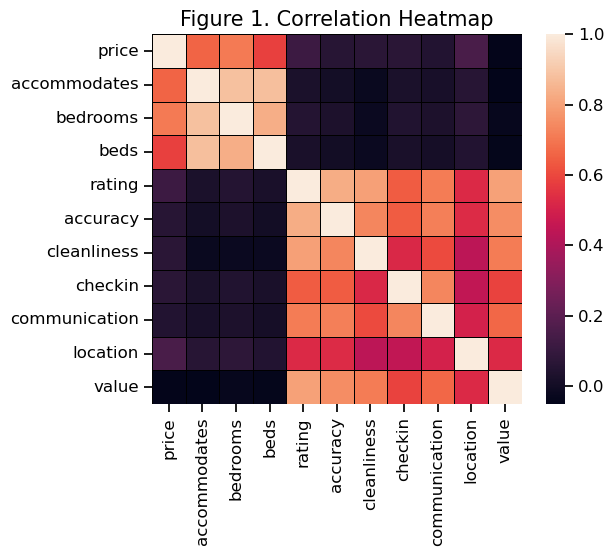

In [241]:
heatmap_col = ['price','accommodates', 'bedrooms', 'beds','review_scores_rating',
               'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                'review_scores_communication','review_scores_location','review_scores_value']
labels = ['price','accommodates', 'bedrooms', 'beds','rating','accuracy','cleanliness','checkin',
         'communication','location','value']
sns.heatmap(train.loc[:,heatmap_col].corr(),linewidths= 0.5, vmax = 1,square = True, linecolor = 'black',
            xticklabels = labels, yticklabels = labels)
plt.title('Figure 1. Correlation Heatmap')
plt.show()

In [ ]:
# select_predictors = ['host_listings_count', 'latitude', 'longitude', 'accommodates', 'bedrooms', 'beds',
#                      'minimum_nights','maximum_nights','number_of_reviews','review_scores_rating',
#                      'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
#                     'review_scores_communication','review_scores_location','review_scores_value',
#                      'reviews_per_month','reviews_per_month']

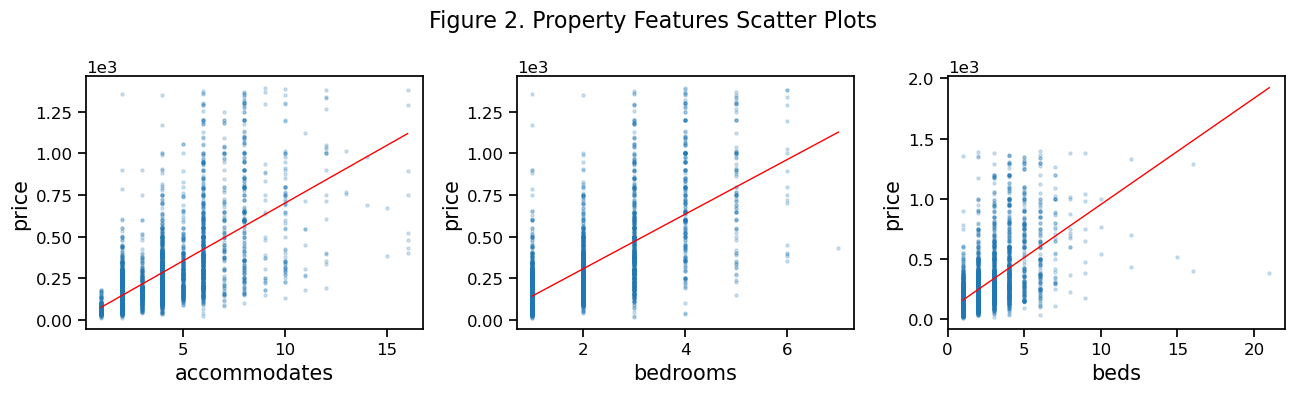

In [246]:
select_predictors = ['accommodates', 'bedrooms', 'beds']

fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for i in range(len(select_predictors)):
    ax = sns.regplot(x=select_predictors[i], y='price', ax=axs[i], data=train, ci=None, 
                scatter_kws={'s':5, 'alpha':0.2}, line_kws={'color':'red', 'linewidth':1})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
fig.suptitle('Figure 2. Property Features Scatter Plots', fontsize=16)
plt.tight_layout()

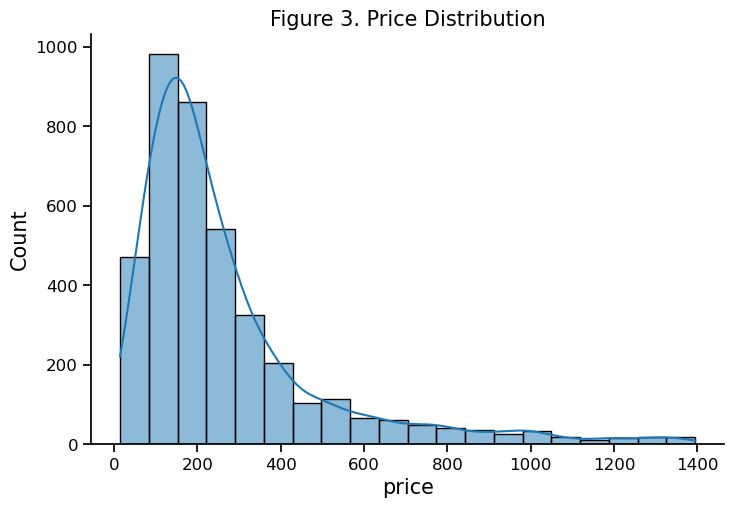

In [253]:
fig = sns.displot(x="price", data=train, kde=True, bins=20, aspect=1.5,edgecolor = 'black')
fig.set(title='Figure 3. Price Distribution')
plt.show()

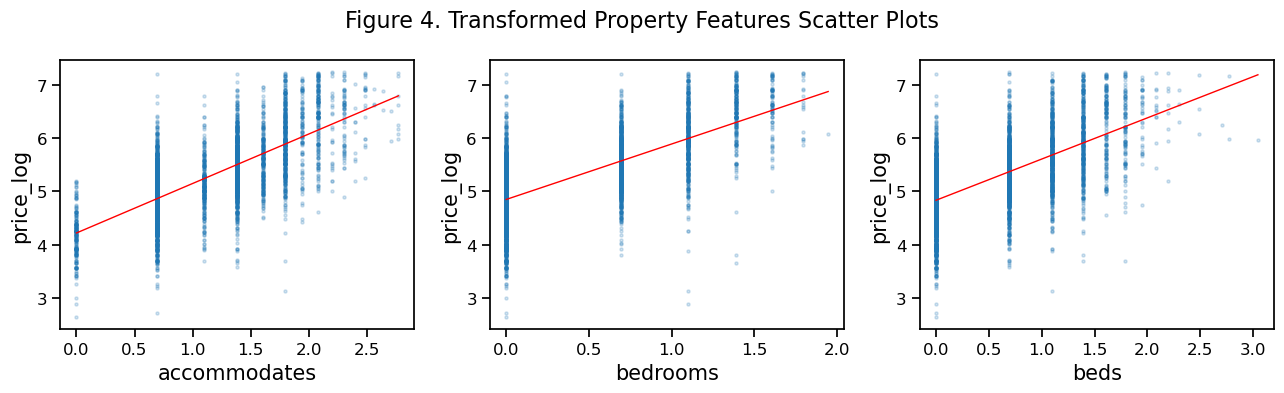

In [256]:
select_predictors = ['accommodates', 'bedrooms', 'beds','price']
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
for i in range(len(select_predictors)-1):
    ax = sns.regplot(x=select_predictors[i], y='price', ax=axs[i], data=np.log(train[select_predictors]), ci=None, 
                scatter_kws={'s':5, 'alpha':0.2}, line_kws={'color':'red', 'linewidth':1})
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.set(xlabel=select_predictors[i],ylabel='price_log')
fig.suptitle('Figure 4. Transformed Property Features Scatter Plots', fontsize=16)
plt.tight_layout()

### 2.2 Location

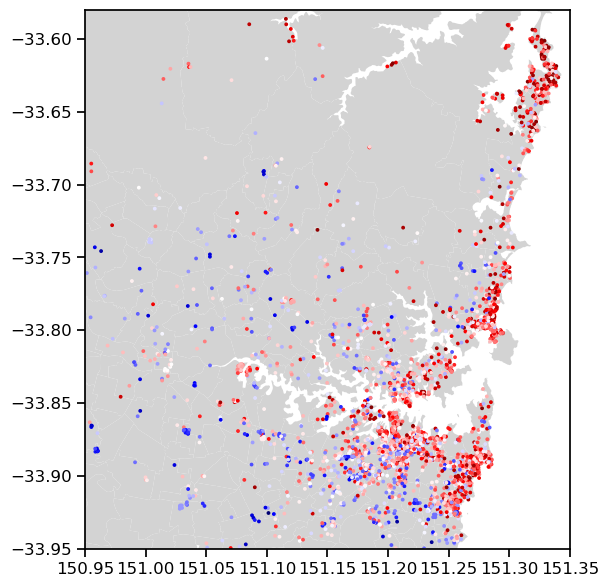

In [104]:
geo_plot.plot(figsize=(10,7),color='lightgrey')
plt.scatter(train["longitude"][:4000],train["latitude"][:4000],c = y_train_log,s= 3,cmap='seismic')
# plt.xlim(150.5,151.5)
# plt.ylim(-34.12,-33.35)

plt.xlim(150.95,151.35)
plt.ylim(-33.95,-33.58)
plt.show()

In [26]:
sydney = gpd.read_file('SA2_sydney/sydney_SA2.shp')
sydney['region'] = sydney['geometry']
geo_train = gpd.GeoDataFrame(train, geometry=gpd.points_from_xy(train.longitude, train.latitude))
sydney.crs = "EPSG:7844"
geo_train.crs = "EPSG:7844"
geo_train_join = gpd.tools.sjoin(geo_train, sydney[['SA2_NAME21','geometry','region']], predicate="within", how='left')

geo_nan = geo_train_join[geo_train_join['SA2_NAME21'].isna()][['latitude','longitude']]
geo_nan = gpd.GeoDataFrame(geo_nan, geometry=gpd.points_from_xy(geo_nan.longitude, geo_nan.latitude))
geo_nan.crs = "EPSG:7844"

In [27]:
for i in geo_nan.index:
    geo_train_join.loc[i,'SA2_NAME21'] = sydney.loc[sydney.distance(geo_nan.loc[i,'geometry']).sort_values().index[0],'SA2_NAME21']

/var/folders/nq/xtfndg6x53g0ffw66wk7g0100000gn/T/ipykernel_96168/2434416798.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_train_join.loc[i,'SA2_NAME21'] = sydney.loc[sydney.distance(geo_nan.loc[i,'geometry']).sort_values().index[0],'SA2_NAME21']


In [ ]:
# location = pd.get_dummies(geo_train_join['SA2_NAME21'])


In [28]:
geo_plot_df = pd.DataFrame(geo_train_join[:4000].groupby('SA2_NAME21').mean()['price'])
geo_plot_df['median'] = geo_train_join[:4000].groupby('SA2_NAME21').median()['price']

In [29]:
sydney_plot = sydney.set_index('SA2_NAME21')
geo_plot = pd.concat([sydney_plot,np.log(geo_plot_df)],axis=1)

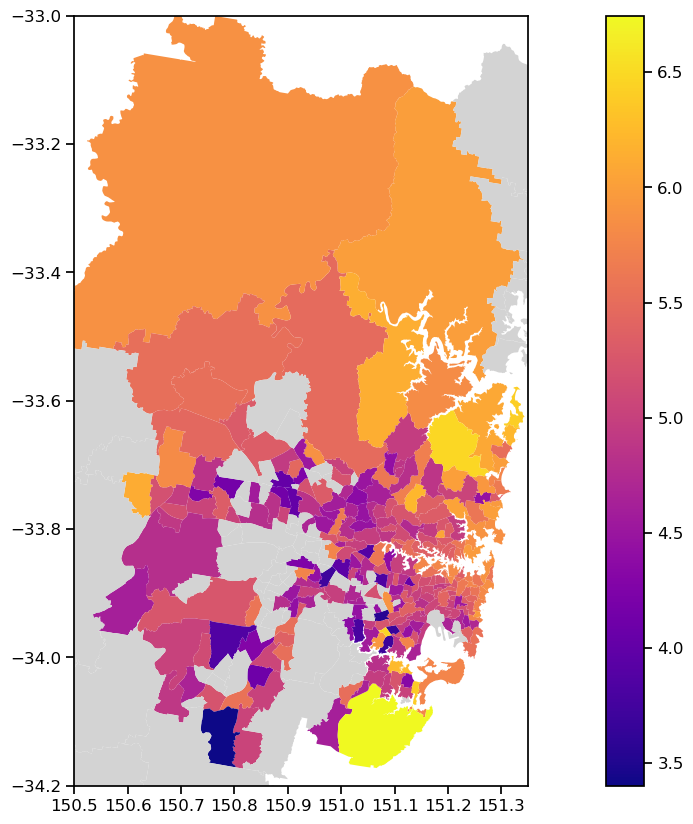

In [30]:
geo_plot.plot(column='price',figsize=(20,10),legend=True,cmap='plasma',missing_kwds= dict(color = "lightgrey"))
plt.xlim(150.5,151.35)
plt.ylim(-34.2,-33)

# plt.xlim(150.88,151.35)
# plt.ylim(-34.1,-33.7)
plt.show()

In [268]:
train['neighbourhood_cleansed'].unique()

array(['Randwick', 'Sydney', 'Waverley', 'Botany Bay', 'Marrickville',
       'The Hills Shire', 'Sutherland Shire', 'Pittwater', 'Woollahra',
       'Leichhardt', 'Warringah', 'Mosman', 'Blacktown', 'Hornsby',
       'Ashfield', 'Ku-Ring-Gai', 'North Sydney', 'Manly', 'Canada Bay',
       'Auburn', 'Willoughby', 'Lane Cove', 'Parramatta', 'Camden',
       'Hurstville', 'Fairfield', 'Ryde', 'Rockdale', 'Penrith',
       'Burwood', 'Canterbury', 'Liverpool', 'City Of Kogarah',
       'Strathfield', 'Holroyd', 'Bankstown', 'Campbelltown',
       'Hunters Hill'], dtype=object)

In [ ]:
# Both Rate Seems to have no relationship with price, they are dropped
# plt.scatter(train["host_response_rate"],y_train_log)
# plt.scatter(train["host_acceptance_rate"],y_train_log)
# plt.scatter(train["host_listings_count"],y_train_log)
# plt.scatter(train['Host_Days'][:4000],y_train_log)

In [ ]:
plt.scatter(train["review_scores_value"][:4000],y_train_log)
plt.xlim(0,5)
plt.show()

In [ ]:
plt.figure(figsize=(5, 4))
plt.hist(y, bins=100);
plt.xlabel('Price (AUD)')
plt.ylabel('Number of listings')
plt.savefig('hist_of_response.png', dpi=300, bbox_inches='tight')

In [ ]:
train[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].corr()

In [ ]:
sns.heatmap(train[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']].corr())
plt.show()

## <font color = '#e64626'><a id='feature_engineering'>3. Feature Engineering</a></font>

In [129]:
# Extract keywords in description: "beach", "city" and "bondi"
corpus_des = [i for i in train['description']]
count_vectorizer = CountVectorizer(binary=True)
count_vectorizer.fit(corpus_des)
features = count_vectorizer.transform(corpus_des)

beach_index = count_vectorizer.get_feature_names_out().tolist().index('beach')
beach = np.array(features[:, beach_index].todense()).reshape(-1)
beach = pd.DataFrame(beach, columns=['beach_dummy'])

city_index = count_vectorizer.get_feature_names_out().tolist().index('city')
city = np.array(features[:, city_index].todense()).reshape(-1)
city = pd.DataFrame(city, columns=['city_dummy'])

bondi_index = count_vectorizer.get_feature_names_out().tolist().index('bondi')
bondi = np.array(features[:, bondi_index].todense()).reshape(-1)
bondi = pd.DataFrame(bondi, columns=['bondiwalk_dummy'])

des_dummies = pd.concat([beach,city,bondi],axis=1)

### Mapping Coordinates to Statistical Area 2 for more precision than neibourbood_cleased

## <font color = '#e64626'><a id='methodology'>4. Methodology</a></font>

### <font color = '#e64626'><a id='model_1'>4.1. Model 1: OLS Lasso</a></font>

In [ ]:
model1_features_all = pd.concat([beach,apartment,walk,host_dummies,host_numbers,acc_room_bed,
                             review_scores,review_numbers,long_lat,location,type_dummies,amenities_df],axis=1)

scaler = StandardScaler()
scaler.fit(model1_features_all)
model1_features_all_scaled = scaler.transform(model1_features_all)

X_scaled = model1_features_all_scaled[:4000]



In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_train_log, test_size = 0.2)

ols = LinearRegression()
ols.fit(X_train_scaled, y_train);

lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)
best_lasso = Lasso(alpha=lasso.alpha_);

In [ ]:
predictors = list(model1_features_all.columns.values)

n_coefs = 15
model = [ols, lasso]
model_name = ['OLS', 'Lasso']
plt.figure(figsize = (10, 10))

for i in range(len(model)):
    betas = model[i].coef_

    indicies = np.argsort(np.abs(betas))[-n_coefs:]
    top_predictors = np.array(predictors)[indicies]
    top_betas = betas[indicies]

    plt.subplot(2, 2, i+1)
    plt.barh(top_predictors, top_betas, alpha=0.5, edgecolor='black')
    sns.despine()
    plt.xlabel('Beta coefficient')
    plt.title(model_name[i]);
plt.suptitle('Figure 5. Top {} Beta Coefficients'.format(n_coefs), fontsize = 16)
plt.tight_layout()

In [ ]:
model = [ols, lasso]
model_name = ['OLS', 'Lasso']
p = len(predictors)

plt.figure(figsize = (12, 10))
for i in range(len(model)):
    plt.subplot(len(model), 1, i+1)
    plt.bar(np.arange(p), model[i].coef_, width=1, alpha=0.5, edgecolor = 'black')
    plt.xticks([])
    plt.xlim([-1.5, p+0.5])
    plt.ylim([-0.1, 0.2])
    plt.ylabel(model_name[i] + '\nBeta Coefficient')
plt.xticks([0, 50, 100, 150])
plt.xlabel('Predictor Number')
plt.suptitle('Figure 6. Comparison of all Beta Coefficients', fontsize=16);

In [ ]:
results = pd.DataFrame(columns=['RMSE', 'R2'])

ols = LinearRegression()
y_pred = cross_val_predict(ols, X_train_scaled, y_train, cv=5)

# OLS sometimes makes crazy predictions so we clip them to something sensible
y_pred = np.clip(y_pred, y_train.min(), y_train.max())

rmse = mean_squared_error(np.exp(y_train), np.exp(y_pred), squared=False)
r2 = r2_score(np.exp(y_train), np.exp(y_pred))

results.loc['OLS'] = rmse, r2

y_pred = cross_val_predict(best_lasso, X_train_scaled, y_train, cv=5)

rmse = mean_squared_error(np.exp(y_train), np.exp(y_pred), squared=False)
r2 = r2_score(np.exp(y_train), np.exp(y_pred))

results.loc['Lasso'] = rmse, r2


In [ ]:
results.round(2)

Now we need to generate the submission file.

In [ ]:
best_lasso.fit(X_scaled,y_train_log)

id_col = np.arange(2000).reshape(-1, 1)
y_pred = np.exp(best_lasso.predict(model1_features_all_scaled[4000:]).reshape(-1, 1))

data = np.hstack((id_col, y_pred))

m1_submission = pd.DataFrame(data, columns=['id', 'price'])
m1_submission['id'] = m1_submission['id'].astype('int')

# m1_submission.to_csv('model1_Lasso_scaled_submission.csv', index=False)

### <font color = '#e64626'><a id='model_2'>4.2. Model 2: *model name*</a></font>

In [ ]:
# X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_train_log, test_size = 0.2)

In [ ]:
# regressor=XGBRegressor(eval_metric='rmse')
# param_grid = {"max_depth":    [6],
#               "n_estimators": [800],
#               "learning_rate": [0.015],
#              'min_child_weight':[0.75]}
# search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)
# xgb=XGBRegressor(learning_rate = search.best_params_["learning_rate"],
#                            n_estimators  = search.best_params_["n_estimators"],
#                            max_depth     = search.best_params_["max_depth"],
#                sampling_method= 'gradient_based',subsample=0.1,tree_method='gpu_hist',
#                  objective='reg:squarederror',booster='gbtree',reg_lambda=0,reg_alpha=0, n_jobs=4,
#                  process_type='default')


In [ ]:
xgb = XGBRegressor(learning_rate = 0.015, n_estimators = 800, max_depth = 6,min_child_weight= 0.75,
                   sampling_method = 'gradient_based', subsample=0.1,tree_method='gpu_hist', 
                   objective='reg:squarederror',booster='gbtree',reg_lambda=0,reg_alpha=0, n_jobs=4,process_type='default')

In [ ]:
xgb.fit(X_train_scaled, y_train)
xgb.score(X_test_scaled,y_test)

In [ ]:
# y_pred = np.exp(xgb.predict(model1_features_all_scaled[4000:]).reshape(-1, 1))

# data = np.hstack((id_col, y_pred))
# m2_submission = pd.DataFrame(data, columns=['id', 'price'])
# m2_submission['id'] = m2_submission['id'].astype('int')

# m2_submission.to_csv('model2_XGBoost_submission.csv', index=False)

### <font color = '#e64626'><a id='model_3'>4.2. Model 3: *Random Forrest*</a></font>

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_train_log, test_size = 0.2)

In [ ]:
model = RandomForestRegressor(random_state=1)

tuning_parameters = {
    'min_samples_leaf': [5],
    'max_features': [100],
    'n_estimators': [600,700,800]
}

rf_cv = GridSearchCV(model, tuning_parameters, cv=5, return_train_score=False, n_jobs=4)
rf_cv.fit(X_train_scaled,y_train)
rf = rf_cv.best_estimator_

rf_cv.best_params_

In [ ]:
rf.fit(X_train_scaled,y_train)
rf.score(X_test_scaled, y_test)

In [ ]:
rf.fit(X_scaled,y_train_log)

In [ ]:
y_pred = np.exp(rf.predict(model1_features_all_scaled[4000:]).reshape(-1, 1))

data = np.hstack((id_col, y_pred))
m3_submission = pd.DataFrame(data, columns=['id', 'price'])
m3_submission['id'] = m3_submission['id'].astype('int')

# m3_submission.to_csv('model3_Random_Forrest_submission2.csv', index=False)

### <font color = '#e64626'><a id='model_4'>4.2. Model 4: *gb_Boost*</a></font>

In [ ]:
gb = GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=2000, subsample=0.5)
gb.fit(X_scaled,y_train_log);

In [ ]:
p = 10

importance = 100*(gb.feature_importances_/np.max(gb.feature_importances_))
feature_importance = pd.Series(importance, index=predictors).sort_values(ascending=True)

plt.barh(np.arange(p), feature_importance[-p:])
plt.yticks(np.arange(p), feature_importance[-p:].index)
plt.xlabel('% of maximum importance')
plt.title('Figure 2. Variable importance of top {} predictors'.format(p));

In [ ]:
gb.score(X_scaled,y_train_log)

In [ ]:
y_pred = np.exp(gb.predict(model1_features_all_scaled[4000:]).reshape(-1, 1))

data = np.hstack((id_col, y_pred))
m4_submission = pd.DataFrame(data, columns=['id', 'price'])
m4_submission['id'] = m4_submission['id'].astype('int')

# m4_submission.to_csv('model4_Gradient_Boost_submission.csv', index=False)

### <font color = '#e64626'><a id='mode_5'>4.2. Model 5: *Model Stack*</a></font>

In [ ]:
models = [('Lasso', best_lasso), ('Random Forest', rf), ('Gradient Boost', gb)]

stack = StackingRegressor(models, final_estimator=LinearRegression(positive=True), cv=5, n_jobs=4)
stack.fit(X_scaled,y_train_log)

In [ ]:
plt.barh(np.arange(len(models)), stack.final_estimator_.coef_)
plt.yticks(np.arange(len(models)), ['Lasso', 'Random Forest', 'Gradient Boost'])
plt.xlabel('Model coefficient')
plt.title('Figure 4. Model coefficients for our stacked model')

In [ ]:
y_pred = np.exp(stack.predict(model1_features_all_scaled[4000:]).reshape(-1, 1))

data = np.hstack((id_col, y_pred))
m5_submission = pd.DataFrame(data, columns=['id', 'price'])
m5_submission['id'] = m5_submission['id'].astype('int')

# m5_submission.to_csv('model5_Stack_Lasso_RF_GB_submission.csv', index=False)

In [ ]:
# Stack test & train

In [ ]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X_scaled, y_train_log, test_size = 0.2)

In [ ]:
models = [('Lasso', best_lasso), ('Random Forest', rf), ('Gradient Boost', gb)]

stack = StackingRegressor(models, final_estimator=LinearRegression(positive=True), cv=5, n_jobs=4)
stack.fit(X_train_scaled,y_train)

In [ ]:
plt.barh(np.arange(len(models)), stack.final_estimator_.coef_)
plt.yticks(np.arange(len(models)), ['Lasso', 'Random Forest', 'Gradient Boost'])
plt.xlabel('Model coefficient')
plt.title('Figure 4. Model coefficients for our stacked model')

In [ ]:
stack.score(X_test_scaled,y_test)